# Goddard problem

## Preliminaries

In [1]:
using ForwardDiff, DifferentialEquations, Plots, LinearAlgebra, MINPACK

In [2]:
# Alias for gradient and jacobian
grad(f, x) = ForwardDiff.gradient(f, x)
jac(f, x)  = ForwardDiff.jacobian(f, x);

## Brackets

In [3]:
function Lie(X, f)
    
    function Xf(x)
        df = grad(f, x)
        return df'*X(x)
    end
    
    return Xf

end
    
#function Lie(X, Y)
#
#    function XY(x)
#        dX = jac(X, x)
#        dY = jac(Y, x)
#        return dY*X(x)-dX*Y(x)
#    end
#
#    return XY
#
#end

function Poisson(f, g)

    function fg(x, p)
        n = size(x, 1)
        ff = z -> f(z[1:n], z[n+1:2n])
        gg = z -> g(z[1:n], z[n+1:2n])
        df = grad(ff, [ x ; p ])
        dg = grad(gg, [ x ; p ])
        return df[n+1:2n]'*dg[1:n] - df[1:n]'*dg[n+1:2n]
    end

    return fg

end;

## OCP

In [4]:
struct Mayer 
    f₀::Function 
    f₁::Function
    control_bounds::Tuple{Number, Number}
    constraint::Union{Function, Nothing}
end
@enum CONTROL min=1 max=2 singular=3 boundary=4

## Flows

In [13]:
# Flow
function __flow(rhs!, tspan, x0, p0; abstol, reltol, saveat)
    z0 = [ x0 ; p0 ]
    n = size(x0, 1)
    ode = ODEProblem(rhs!, z0, tspan, n)
    sol = OrdinaryDiffEq.solve(ode, Tsit5(), abstol=abstol, reltol=reltol, saveat=saveat)
    return sol
end

function __flow(rhs!, t0, x0, p0, tf; abstol, reltol, saveat)
    sol = __flow(rhs!, (t0, tf), x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
    n = size(x0, 1)
    return sol[1:n, end], sol[n+1:2n, end]
end

function __abstol()
    return 1e-8
end

function __reltol()
    return 1e-8
end

function __saveat()
    return []
end

function __dh(ocp::Mayer)
    
    f₀ = ocp.f₀
    f₁ = ocp.f₁
    h₀(x, p) = p'*f₀(x)
    h₁(x, p) = p'*f₁(x)
    
    function dh₀(x, p)
        n = size(x, 1)
        foo(z) = h₀(z[1:n], z[n+1:2n])
        return grad(foo, [x; p])
    end

    function dh₁(x, p)
        n = size(x, 1)
        foo(z) = h₁(z[1:n], z[n+1:2n])
        return grad(foo, [x; p])
    end
    
    return dh₀, dh₁
    
end

function __FlowMIN(ocp::Mayer)
  
    u_bounds = ocp.control_bounds
    dh₀, dh₁ = __dh(ocp)
        
    function rhs!(dz, z, n, t)
        x   = z[1:n]
        p   = z[n+1:2n]
        u   = u_bounds[1]
        dh0 = dh₀(x, p)
        dh1 = dh₁(x, p)
        hv0 = [dh0[n+1:2n]; -dh0[1:n]]
        hv1 = [dh1[n+1:2n]; -dh1[1:n]]
        dz[1:2n] = hv0 + u*hv1
    end
    
    function f(tspan, x0, p0; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, tspan, x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    function f(t0, x0, p0, tf; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, t0, x0, p0, tf, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    return f

end;

function __FlowMAX(ocp::Mayer)
  
    u_bounds = ocp.control_bounds
    dh₀, dh₁ = __dh(ocp)
        
    function rhs!(dz, z, n, t)
        x   = z[1:n]
        p   = z[n+1:2n]
        u   = u_bounds[2]
        dh0 = dh₀(x, p)
        dh1 = dh₁(x, p)
        hv0 = [dh0[n+1:2n]; -dh0[1:n]]
        hv1 = [dh1[n+1:2n]; -dh1[1:n]]
        dz[1:2n] = hv0 + u*hv1
    end
    
    function f(tspan, x0, p0; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, tspan, x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    function f(t0, x0, p0, tf; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, t0, x0, p0, tf, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    return f

end;

function __us(ocp::Mayer)
    
    f₀ = ocp.f₀
    f₁ = ocp.f₁
    h₀(x, p) = p'*f₀(x)
    h₁(x, p) = p'*f₁(x)  
    
    # singular control
    H₀₁  = Poisson(h₀, h₁)
    H₀₀₁ = Poisson(h₀, H₀₁)
    H₁₀₁ = Poisson(h₁, H₀₁)
    us(x, p) = -H₀₀₁(x, p)/H₁₀₁(x, p)  
    
    return us
    
end

function __FlowSING(ocp::Mayer)
  
    dh₀, dh₁ = __dh(ocp)
    us =  __us(ocp)
        
    function rhs!(dz, z, n, t)
        x   = z[1:n]
        p   = z[n+1:2n]
        u   = us(x, p)
        dh0 = dh₀(x, p)
        dh1 = dh₁(x, p)
        hv0 = [dh0[n+1:2n]; -dh0[1:n]]
        hv1 = [dh1[n+1:2n]; -dh1[1:n]]
        dz[1:2n] = hv0 + u*hv1
    end
    
    function f(tspan, x0, p0; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, tspan, x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    function f(t0, x0, p0, tf; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, t0, x0, p0, tf, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    return f, us

end;

function __u_μ_boundary(ocp::Mayer)
    f₀ = ocp.f₀
    f₁ = ocp.f₁
    h₀(x, p) = p'*f₀(x)
    h₁(x, p) = p'*f₁(x)  
    H₀₁ = Poisson(h₀, h₁)   
    g = ocp.constraint
    ub(x) = -Lie(f₀, g)(x) / Lie(f₁, g)(x)
    μb(x, p) = H₀₁(x, p) / Lie(f₁, g)(x)
    ∇g(x) = grad(g, x)
    return ub, μb, ∇g
end

function __FlowBOUND(ocp::Mayer)
  
    dh₀, dh₁ = __dh(ocp)
    ub, μb, ∇g = __u_μ_boundary(ocp)
    
    function rhs!(dz, z, n, t)
        x   = z[1:n]
        p   = z[n+1:2n]
        u   = ub(x)
        μ   = μb(x, p)
        dh0 = dh₀(x, p)
        dh1 = dh₁(x, p)
        hv0 = [dh0[n+1:2n]; -dh0[1:n]]
        hv1 = [dh1[n+1:2n]; -dh1[1:n]]
        dz[1:2n] = hv0 + u*hv1
        dz[n+1:2n] = dz[n+1:2n] - μ*∇g(x)
    end
    
    function f(tspan, x0, p0; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, tspan, x0, p0, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    function f(t0, x0, p0, tf; abstol=__abstol(), reltol=__reltol(), saveat=__saveat())
        return __flow(rhs!, t0, x0, p0, tf, abstol=abstol, reltol=reltol, saveat=saveat)
    end
    
    return f, ub, μb

end;

function Flow(ocp::Mayer, control::CONTROL)
    if control==singular
        return __FlowSING(ocp)
    elseif control==min
        return __FlowMIN(ocp)
    elseif control==max
        return __FlowMAX(ocp)
    elseif control==boundary
        return __FlowBOUND(ocp)
    else
        nothing
    end    
end;

## Problem

In [14]:
# Parameters
Cd = 310.0
Tmax = 3.5
β = 500.0
b = 2.0
t0 = 0.0
r0 = 1.0
v0 = 0.0
vmax = 0.1
m0 = 1.0
x0 = [ r0, v0, m0 ]
mf = 0.6;
n = length(x0)

# Dynamics
function F0(x)
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r-1.0))
    F = [ v, -D/m-1.0/r^2, 0.0 ]
    return F
end

function F1(x)
    r, v, m = x
    F = [ 0.0, Tmax/m, -b*Tmax ]
    return F
end

# State constraint
g(x) = vmax-x[2] # vmax - v ≥ 0

# ocp
ocp = Mayer(F0, F1, (0.0, 1.0), g)

# Flows
f0 = Flow(ocp, min);
fr = Flow(ocp, max);
fs, us = Flow(ocp, singular);
fb, ub, μb = Flow(ocp, boundary);

#
H0(x, p) = p'*F0(x)
H1(x, p) = p'*F1(x)
H01 = Poisson(H0, H1);

## Indirect

In [15]:
# Shooting function
function shoot(p0, t1, t2, t3, tf) # B+ S C B0 structure

    x1, p1 = fr(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    x3, p3 = fb(t2, x2, p2, t3)
    xf, pf = f0(t3, x3, p3, tf)
    s = zeros(eltype(p0), 7)
    s[1:2] = pf[1:2] - [ 1.0, 0.0 ]
    s[3] = xf[3] - mf # supposed to be active
    s[4] = H1(x1, p1)
    s[5] = H01(x1, p1)
    s[6] = g(x2)
    s[7] = H0(xf, pf) # free tf

    return s

end;

In [16]:
ξ = [3.94288, 0.146288, 0.0541244, 0.02524675, 0.06160209, 0.1040166, 0.202983945]; # to change and use direct solution

In [19]:
# Solve
foo(ξ) = shoot(ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7])
jfoo(ξ) = ForwardDiff.jacobian(foo, ξ)
foo!(s, ξ) = ( s[:] = foo(ξ); nothing )
jfoo!(js, ξ) = ( js[:] = jfoo(ξ); nothing )

println("Initial value of shooting:\n", foo(ξ), "\n\n")

nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)
#nl_sol = fsolve(foo!, ξ, show_trace=true); println(nl_sol);

# Retrieves solution
if nl_sol.converged
    p0 = nl_sol.x[1:3]
    t1 = nl_sol.x[4]
    t2 = nl_sol.x[5]
    t3 = nl_sol.x[6]
    tf = nl_sol.x[7];
else
    error("Not converged")
end

Initial value of shooting:
[-0.0514623439767391, -0.002967522724881946, -0.027364299428959682, -0.0270151163166652, -0.21567976587082738, -0.015226716010912994, 0.019441411387060722]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     2.156798e-01     0.000000e+00         0.037390
     2     1.335706e-01     4.526744e-03         0.227345
     3     5.498089e-02     1.070072e-03         0.028760
     4     1.296502e-02     7.862867e-04         0.020345
     5     2.213314e-03     1.216604e-05         0.047277
     6     6.888948e-04     1.250452e-07         0.010444
     7     2.129216e-04     1.312578e-08         0.020906
     8     7.482234e-06     2.264847e-09         0.024043
     9     4.367260e-07     2.809007e-12         0.011594
    10     8.371502e-08     7.748493e-15         0.010620
    11     3.736671e-09     3.658630e-16         0.015146
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powel

0.20204744039366834

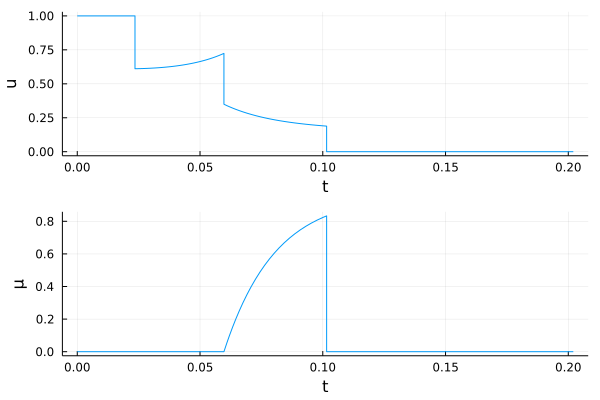

In [10]:
# Plots
ode_sol = fr((t0, t1), x0, p0)
tt0 = ode_sol.t
xx0 = [ ode_sol[1:n, j] for j in 1:size(tt0, 1) ]
pp0 = [ ode_sol[n+1:2n, j] for j in 1:size(tt0, 1) ]
uu0 = ones(size(tt0, 1))
μ0  = zeros(size(tt0, 1))

ode_sol = fs((t1, t2), xx0[end], pp0[end])
tt1 = ode_sol.t
xx1 = [ ode_sol[1:n, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[n+1:2n, j] for j in 1:size(tt1, 1) ]
uu1 = us.(xx1, pp1)
μ1  = zeros(size(tt1, 1))

ode_sol = fb((t2, t3), xx1[end], pp1[end])
tt2 = ode_sol.t
xx2 = [ ode_sol[1:n, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[n+1:2n, j] for j in 1:size(tt2, 1) ]
uu2 = ub.(xx2)
μ2  = μb.(xx2, pp2)

ode_sol = f0((t3, tf), xx2[end], pp2[end])
tt3 = ode_sol.t
xx3 = [ ode_sol[1:n, j] for j in 1:size(tt3, 1) ]
pp3 = [ ode_sol[n+1:2n, j] for j in 1:size(tt3, 1) ]
uu3 = zeros(size(tt3, 1))
μ3  = zeros(size(tt3, 1))

t = [ tt0 ; tt1 ; tt2 ; tt3 ]
x = [ xx0 ; xx1 ; xx2 ; xx3 ]
p = [ pp0 ; pp1 ; pp2 ; pp3 ]
u = [ uu0 ; uu1 ; uu2 ; uu3 ]
μ = [ μ0  ; μ1  ; μ2  ; μ3  ]
N = length(t)

r_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "r", legend = false)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false)
m_plot  = plot(t, [ x[i][3] for i=1:N ], xlabel = "t", ylabel = "m", legend = false)
pr_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "pr", legend = false)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false)
pm_plot = plot(t, [ p[i][3] for i=1:N ], xlabel = "t", ylabel = "pm", legend = false)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false)
μ_plot  = plot(t, μ, xlabel = "t", ylabel = "μ", legend = false)
display(plot(r_plot, v_plot, m_plot, pr_plot, pv_plot, pm_plot, layout = (2,3)))
display(plot(u_plot, μ_plot, layout = (2,1)))